In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import qiskit as qk
#qk.IBMQ.load_account()

from system import Model,Pairing,Heisenberg
from algorithms import PhaseEstimation

In [2]:
def binaryfrac(bitstr):
    val = 0
    for i,bit in enumerate(bitstr):
        val += int(bit)*(2**(-i-1))
    return val

### Define variables and model class

In [3]:
dt = 0.004
steps = 120
t = steps*dt

h0 = 1
delta = 1
g = 1
Emax = 2
sim = 4
work = 6
ancilla = 1
#model = Pairing(6,4,1,3,1,1)
model = Heisenberg(8,2,0,5,1)

## Do phase estimation

In [4]:
#model = Model(work,sim,ancilla,Emax,*args)
model = PhaseEstimation(model,t=t,dt=dt)

In [5]:
# Measurement
model = model.measurePhase(t)

### Plot results

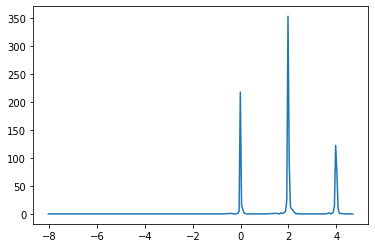

In [6]:
x = model.plotX
y = model.plotY
plt.plot(x,y)
plt.show()

Measurement: 12 (218)
  - Eigenstate: 10 => Ek = -0.011003907093094512


Measurement: 13 (16)
  - Eigenstate: 11 => Ek = 0.040128785836427205


Measurement: 28 (25)
  - Eigenstate: 10 => Ek = 1.9320384242287179


Measurement: 29 (353)
  - Eigenstate: 10 => Ek = 1.9831711171582391


Measurement: 30 (92)
  - Eigenstate: 01 => Ek = 2.0343038100877604


Measurement: 31 (13)
  - Eigenstate: 10 => Ek = 2.0854365030172817


Measurement: 47 (15)
  - Eigenstate: 01 => Ek = 3.926213448480051


Measurement: 48 (123)
  - Eigenstate: 01 => Ek = 3.9773461414095728


Measurement: 49 (75)
  - Eigenstate: 01 => Ek = 4.028478834339094




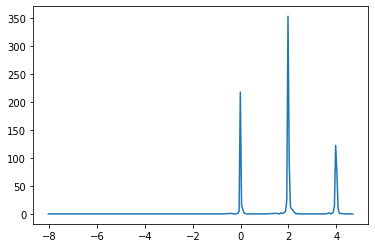

In [7]:
result = model.result
a = model.a
s = model.s
w = model.w
N = model.N
Emax = model.Emax
x = [] # phase
y = [] # hits
V = []
for key,val in result.items():
    eigenstate = key[a:s+a]
    eigenstate = eigenstate[::-1]
    phi = key[N-w:]
    x.append(Emax - 2*np.pi*binaryfrac(phi)/t)
    y.append(val)
    V.append(eigenstate)
x = np.array(x)
y = np.array(y)
V = np.array(V)
idx = np.argsort(x)
x = x[idx]
y = y[idx]
V = V[idx]
## Check if same phase measured for different eigenstates
x_ = []
y_ = []
for i,xi in enumerate(x):
    if i > 0:
        if xi == x_[-1]:
            y_[-1] += y[i]
            #print(V[-1],V[i])
        else:
            x_.append(xi)
            y_.append(y[i])

    else:
        x_.append(xi)
        y_.append(y[i])
        
        
for i,xi in enumerate(x_):
    if y_[i] > 10:
        print('Measurement: {} ({})'.format(i,y_[i]))
        print('  - Eigenstate: {} => Ek = {}'.format(V[i],xi))
        print('\n')
        
plt.plot(x_,y_)

In [8]:
def VariationalQuantumEigensolver(model,max_it=100,optimizer='powell'):
    qc = model.qc
    qb = model.qb
    
    for i in range(max_it):
        model.ansatz('vqe')
        model.Hamiltonian()
    
    

In [9]:
print('PE'.lower())
print('Pe'.lower())
print('pE'.lower())
print('pe'.lower())

pe
pe
pe
pe
